In [1]:
%load_ext rpy2.ipython
%matplotlib inline

from prophet import Prophet
import pandas as pd
import numpy as np
import logging
import warnings

logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [2]:
df = pd.DataFrame({
    'ds': pd.date_range(start='2020-01-01', periods=20),
    'y': np.arange(20),
})
m = Prophet(weekly_seasonality=False)
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
%%R
library(prophet)
df <- data.frame(
    ds=seq(as.Date("2020-01-01"), by = "day", length.out = 20),
    y=1:20
)
m <- prophet(df, weekly.seasonality=FALSE)

R[write to console]: Loading required package: Rcpp

R[write to console]: Loading required package: rlang

R[write to console]: Disabling yearly seasonality. Run prophet with yearly.seasonality=TRUE to override this.

R[write to console]: Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

R[write to console]: n.changepoints greater than number of observations. Using 15



### Saving models

It is possible to save fitted Prophet models so that they can be loaded and used later.

In R, this is done with `saveRDS` and `readRDS`:

In [3]:
%%R
saveRDS(m, file="model.RDS")  # Save model
m <- readRDS(file="model.RDS")  # Load model

In Python, models should not be saved with pickle; the Stan backend attached to the model object will not pickle well, and will produce issues under certain versions of Python. Instead, you should use the built-in serialization functions to serialize the model to json:

In [3]:
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

The json file will be portable across systems, and deserialization is backwards compatible with older versions of prophet.

### Flat trend

For time series that exhibit strong seasonality patterns rather than trend changes, or when we want to rely on the pattern of exogenous regressors (e.g. for causal inference with time series), it may be useful to force the trend growth rate to be flat. This can be achieved simply by passing `growth='flat'` when creating the model:

In [4]:
%%R
m <- prophet(df, growth='flat')

R[write to console]: Disabling yearly seasonality. Run prophet with yearly.seasonality=TRUE to override this.

R[write to console]: Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

R[write to console]: n.changepoints greater than number of observations. Using 15



In [4]:
m = Prophet(growth='flat')

Below is a comparison of counterfactual forecasting with exogenous regressors using linear versus flat growth.

In [3]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

regressor = "location_4"
target = "location_41"
cutoff = pd.to_datetime("2023-04-17 00:00:00")

df = (
    pd.read_csv(
        "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_multivariate.csv", 
        parse_dates=["ds"]
    )
    .rename(columns={target: "y"})
)
train = df.loc[df["ds"] < cutoff]
test = df.loc[df["ds"] >= cutoff]

In [105]:
def fit_model(growth):
    m = Prophet(growth=growth, seasonality_mode="multiplicative", daily_seasonality=15)
    m.add_regressor("location_4", mode="multiplicative")
    m.fit(train)
    preds = pd.merge(
        test,
        m.predict(test),
        on="ds",
        how="inner"
    )
    mape = ((preds["yhat"] - preds["y"]).abs() / preds_linear["y"]).mean()
    return m, preds, mape

In [106]:
m_linear, preds_linear, mape_linear = fit_model("linear")

01:19:58 - cmdstanpy - INFO - Chain [1] start processing
01:19:58 - cmdstanpy - INFO - Chain [1] done processing


In [107]:
m_flat, preds_flat, mape_flat = fit_model("flat")

01:19:58 - cmdstanpy - INFO - Chain [1] start processing
01:19:58 - cmdstanpy - INFO - Chain [1] done processing


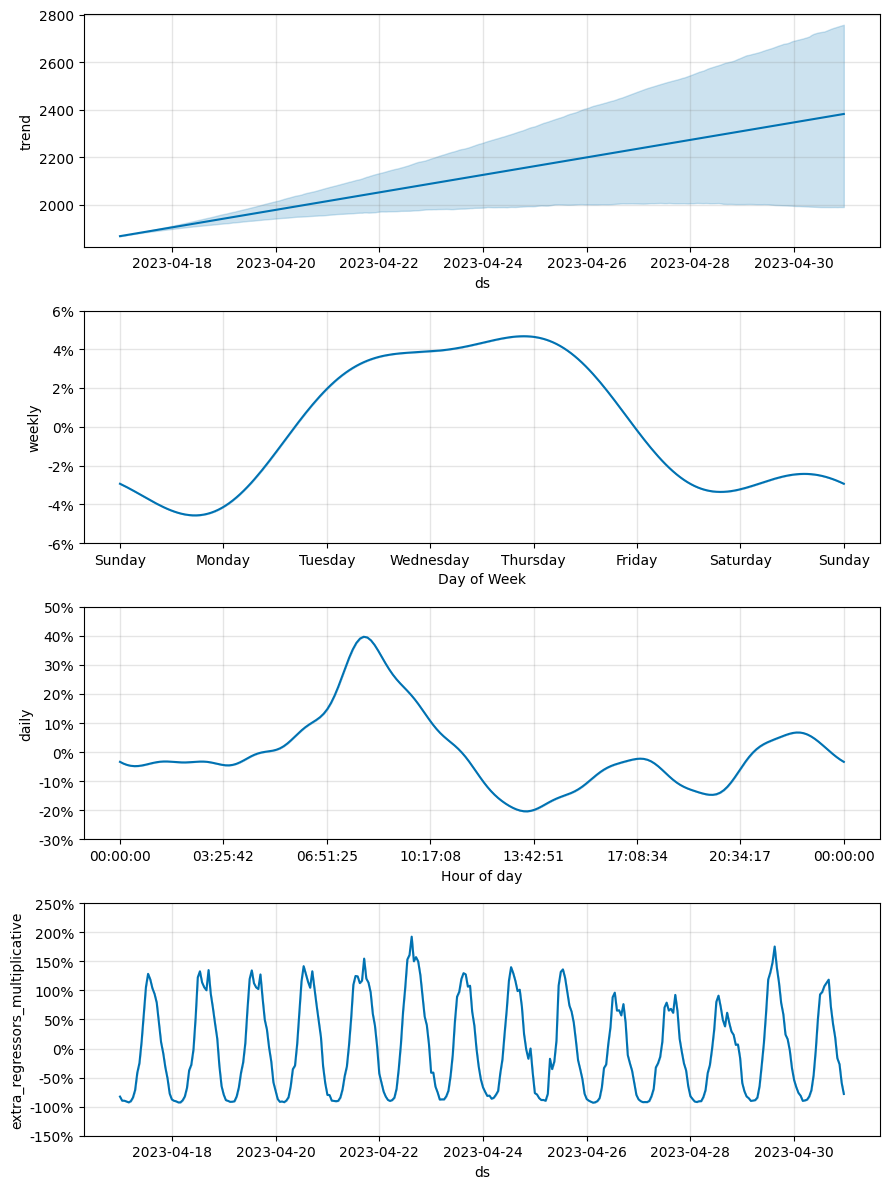

In [108]:
m_linear.plot_components(preds_linear);

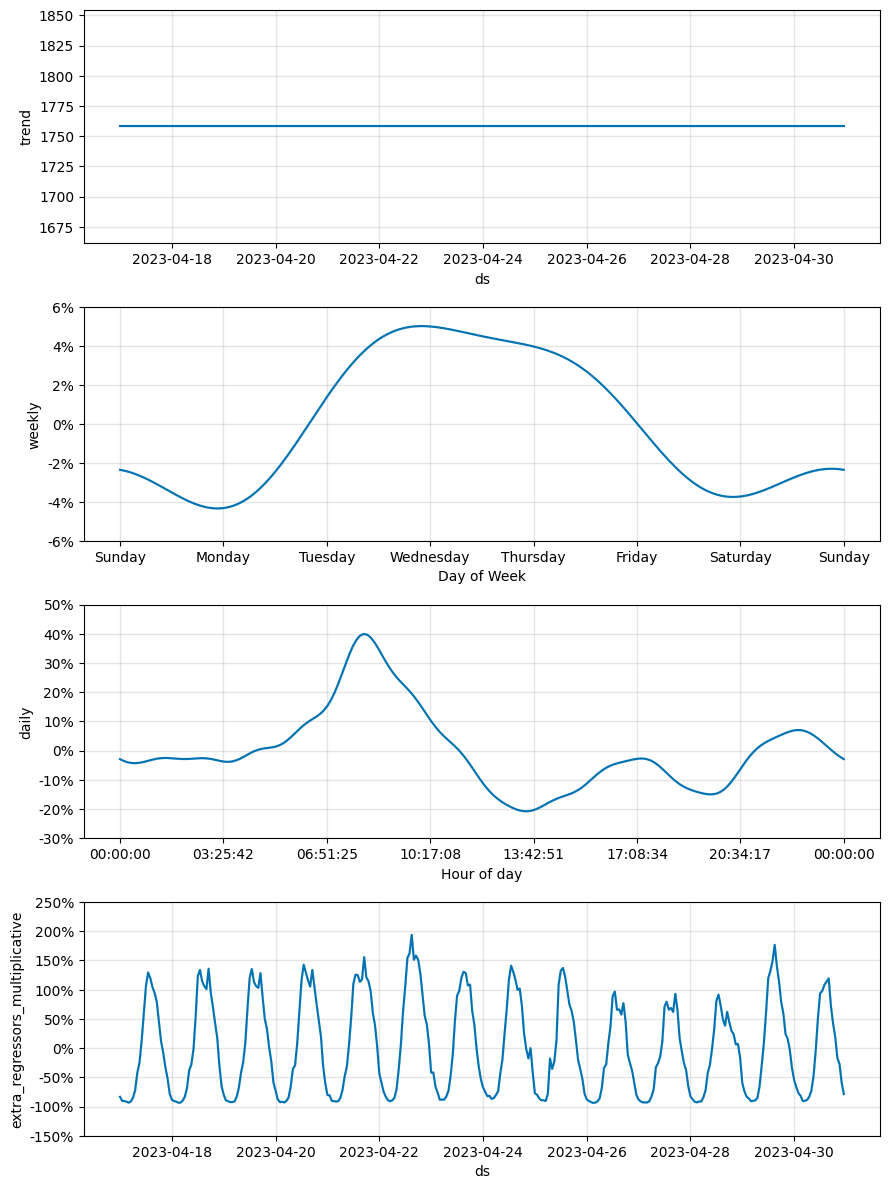

In [109]:
m_flat.plot_components(preds_flat);

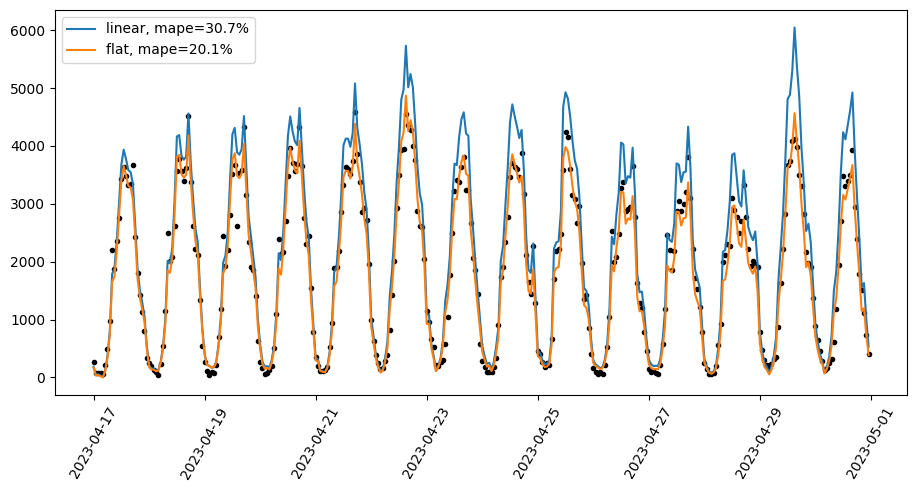

In [124]:
fig, ax = plt.subplots(figsize=(11, 5))
ax.scatter(preds_linear["ds"], preds_linear["y"], color="black", marker=".")
ax.plot(preds_linear["ds"], preds_linear["yhat"], label=f"linear, mape={mape_linear:.1%}")
ax.plot(preds_flat["ds"], preds_flat["yhat"], label=f"flat, mape={mape_flat:.1%}")
plt.xticks(rotation=60)
ax.legend();

In this example, the target sensor values can be mostly explained by the exogenous regressor (a nearby sensor). The model with linear growth assumes an increasing trend and this leads to larger and larger over-predictions in the test period, while the flat growth model mostly follows movements in the exogenous regressor and this results in a sizeable MAPE improvement.

Note that forecasting with exogenous regressors is only effective when we can be confident in the future values of the regressor. The example above is relevant to causal inference using time series, where we want to understand what `y` would have looked like for a past time period, and hence the exogenous regressor values are known.

In other cases -- where we don't have exogenous regressors or have to predict their future values -- if flat growth is used on a time series that doesn't have a constant trend, any trend will be fit with the noise term and so there will be high predictive uncertainty in the forecast.

### Custom trends

To use a trend besides these three built-in trend functions (piecewise linear, piecewise logistic growth, and flat), you can download the source code from github, modify the trend function as desired in a local branch, and then install that local version. [This PR](https://github.com/facebook/prophet/pull/1466/files) provides a good illustration of what must be done to implement a custom trend, as does [this one](https://github.com/facebook/prophet/pull/1794) that implements a step function trend and [this one](https://github.com/facebook/prophet/pull/1778) for a new trend in R.

### Updating fitted models

A common setting for forecasting is fitting models that need to be updated as additional data come in. Prophet models can only be fit once, and a new model must be re-fit when new data become available. In most settings, model fitting is fast enough that there isn't any issue with re-fitting from scratch. However, it is possible to speed things up a little by warm-starting the fit from the model parameters of the earlier model. This code example shows how this can be done in Python:

In [5]:
def warm_start_params(m):
    """
    Retrieve parameters from a trained model in the format used to initialize a new Stan model.
    Note that the new Stan model must have these same settings:
        n_changepoints, seasonality features, mcmc sampling
    for the retrieved parameters to be valid for the new model.

    Parameters
    ----------
    m: A trained model of the Prophet class.

    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        if m.mcmc_samples == 0:
            res[pname] = m.params[pname][0][0]
        else:
            res[pname] = np.mean(m.params[pname])
    for pname in ['delta', 'beta']:
        if m.mcmc_samples == 0:
            res[pname] = m.params[pname][0]
        else:
            res[pname] = np.mean(m.params[pname], axis=0)
    return res

df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df1 = df.loc[df['ds'] < '2016-01-19', :]  # All data except the last day
m1 = Prophet().fit(df1) # A model fit to all data except the last day


%timeit m2 = Prophet().fit(df)  # Adding the last day, fitting from scratch
%timeit m2 = Prophet().fit(df, init=warm_start_params(m1))  # Adding the last day, warm-starting from m1

1.33 s ± 55.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
185 ms ± 4.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


As can be seen, the parameters from the previous model are passed in to the fitting for the next with the kwarg `init`. In this case, model fitting was about 5x faster when using warm starting. The speedup will generally depend on how much the optimal model parameters have changed with the addition of the new data.

There are few caveats that should be kept in mind when considering warm-starting. First, warm-starting may work well for small updates to the data (like the addition of one day in the example above) but can be worse than fitting from scratch if there are large changes to the data (i.e., a lot of days have been added). This is because when a large amount of history is added, the location of the changepoints will be very different between the two models, and so the parameters from the previous model may actually produce a bad trend initialization. Second, as a detail, the number of changepoints need to be consistent from one model to the next or else an error will be raised because the changepoint prior parameter `delta` will be the wrong size.

### minmax scaling (new in 1.1.5)

Before model fitting, Prophet scales `y` by dividing by the maximum value in the history. For datasets with very large `y` values, the scaled `y` values may be compressed to a very small range (i.e. `[0.99999... - 1.0]`), which causes a bad fit. This can be fixed by setting `scaling='minmax'` in the Prophet constructor.

In [4]:
large_y = pd.read_csv(
    "https://raw.githubusercontent.com/facebook/prophet/main/python/prophet/tests/data3.csv", 
    parse_dates=["ds"]
)

In [5]:
m1 = Prophet(scaling="absmax")
m1 = m1.fit(large_y)

08:11:23 - cmdstanpy - INFO - Chain [1] start processing
08:11:23 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
m2 = Prophet(scaling="minmax")
m2 = m2.fit(large_y)

08:11:29 - cmdstanpy - INFO - Chain [1] start processing
08:11:29 - cmdstanpy - INFO - Chain [1] done processing


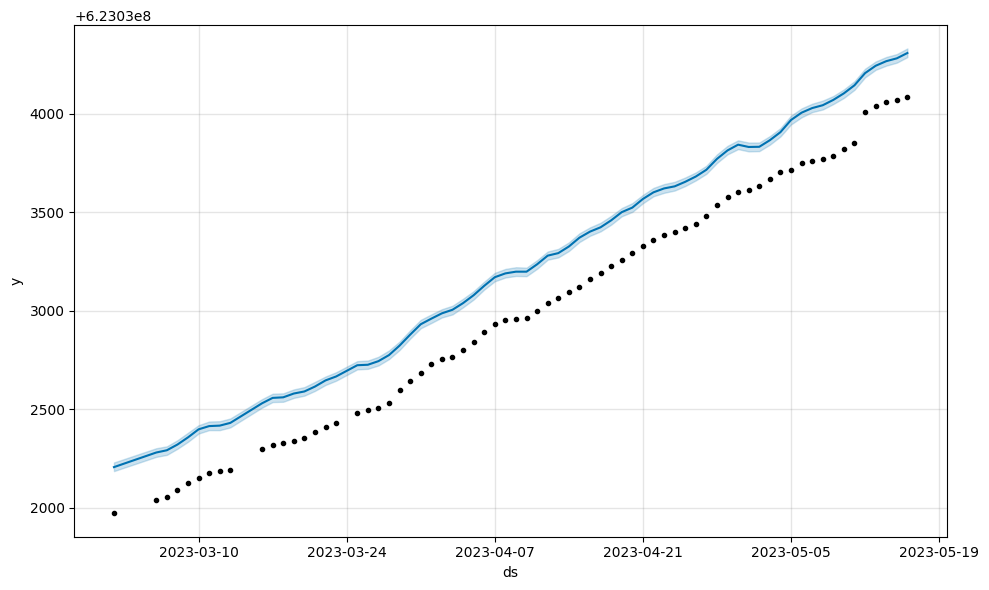

In [119]:
m1.plot(m1.predict(large_y));

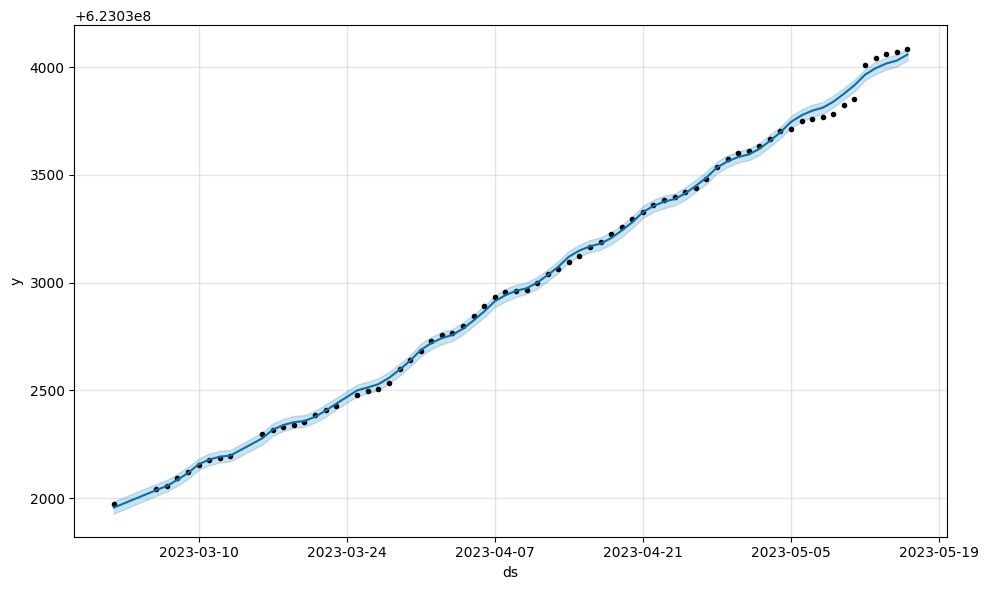

In [120]:
m2.plot(m2.predict(large_y));

### Inspecting transformed data (new in 1.1.5)

For debugging, it's useful to understand how the raw data has been transformed before being passed to the stan fit routine. We can call the `.preprocess()` method to see all the inputs to stan, and `.calculate_init_params()` to see how the model parameters will be initialized.

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
m = Prophet()
transformed = m.preprocess(df)

In [14]:
transformed.y.head(n=10)

0    0.746552
1    0.663171
2    0.637023
3    0.628367
4    0.614441
5    0.605884
6    0.654956
7    0.687273
8    0.652501
9    0.628148
Name: y_scaled, dtype: float64

In [15]:
transformed.X.head(n=10)

,yearly_delim_1,yearly_delim_2,yearly_delim_3,yearly_delim_4,yearly_delim_5,yearly_delim_6,yearly_delim_7,yearly_delim_8,yearly_delim_9,yearly_delim_10,...,yearly_delim_17,yearly_delim_18,yearly_delim_19,yearly_delim_20,weekly_delim_1,weekly_delim_2,weekly_delim_3,weekly_delim_4,weekly_delim_5,weekly_delim_6
0,-0.377462,0.926025,-0.699079,0.715044,-0.917267,0.398272,-0.999745,0.022576,-0.934311,-0.356460,...,0.335276,-0.942120,0.666089,-0.745872,-4.338837e-01,-0.900969,7.818315e-01,0.623490,-9.749279e-01,-0.222521
1,-0.361478,0.932381,-0.674069,0.738668,-0.895501,0.445059,-0.995827,0.091261,-0.961479,-0.274879,...,0.185987,-0.982552,0.528581,-0.848883,-9.749279e-01,-0.222521,4.338837e-01,-0.900969,7.818315e-01,0.623490
2,-0.345386,0.938461,-0.648262,0.761418,-0.871351,0.490660,-0.987196,0.159513,-0.981538,-0.191266,...,0.032249,-0.999480,0.375470,-0.926834,-7.818315e-01,0.623490,-9.749279e-01,-0.222521,-4.338837e-01,-0.900969
3,-0.329192,0.944263,-0.621687,0.783266,-0.844881,0.534955,-0.973892,0.227011,-0.994341,-0.106239,...,-0.122261,-0.992498,0.211276,-0.977426,5.505235e-14,1.000000,1.101047e-13,1.000000,1.984146e-12,1.000000
4,-0.312900,0.949786,-0.594376,0.804187,-0.816160,0.577825,-0.955979,0.293434,-0.999791,-0.020426,...,-0.273845,-0.961774,0.040844,-0.999166,7.818315e-01,0.623490,9.749279e-01,-0.222521,4.338837e-01,-0.900969
5,-0.296516,0.955028,-0.566362,0.824157,-0.785267,0.619157,-0.933542,0.358468,-0.997850,0.065537,...,-0.418879,-0.908042,-0.130793,-0.991410,9.749279e-01,-0.222521,-4.338837e-01,-0.900969,-7.818315e-01,0.623490
6,-0.280044,0.959987,-0.537677,0.843151,-0.752283,0.658840,-0.906686,0.421806,-0.988531,0.151016,...,-0.553893,-0.832588,-0.298569,-0.954388,4.338837e-01,-0.900969,-7.818315e-01,0.623490,9.749279e-01,-0.222521
7,-0.263489,0.964662,-0.508356,0.861147,-0.717295,0.696769,-0.875539,0.483147,-0.971904,0.235379,...,-0.675656,-0.737217,-0.457531,-0.889193,-4.338837e-01,-0.900969,7.818315e-01,0.623490,-9.749279e-01,-0.222521
8,-0.246857,0.969052,-0.478434,0.878124,-0.680398,0.732843,-0.840248,0.542202,-0.948090,0.318001,...,-0.781257,-0.624210,-0.602988,-0.797750,-9.749279e-01,-0.222521,4.338837e-01,-0.900969,7.818315e-01,0.623490
9,-0.230151,0.973155,-0.447945,0.894061,-0.641689,0.766965,-0.800980,0.598691,-0.917267,0.398272,...,-0.868168,-0.496271,-0.730644,-0.682758,-7.818315e-01,0.623490,-9.749279e-01,-0.222521,-4.338837e-01,-0.900969


In [16]:
m.calculate_initial_params(num_total_regressors=transformed.K)

ModelParams(k=-0.05444079622224118, m=0.7465517318876905, delta=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]), beta=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.]), sigma_obs=1.0)

### External references

As we discuss in our [2023 blog post on the state of Prophet](https://medium.com/@cuongduong_35162/facebook-prophet-in-2023-and-beyond-c5086151c138), we have no plans to further develop the underlying Prophet model. If you're looking for state-of-the-art forecasting accuracy, we recommend the following libraries:

* [`statsforecast`](https://github.com/Nixtla/statsforecast), and other packages from the Nixtla group such as [`hierarchicalforecast`](https://github.com/Nixtla/hierarchicalforecast) and [`neuralforecast`](https://github.com/Nixtla/neuralforecast).
* [`NeuralProphet`](https://neuralprophet.com/), a Prophet-style model implemented in PyTorch, to be more adaptable and extensible.

These github repositories provide examples of building on top of Prophet in ways that may be of broad interest:

* [forecastr](https://github.com/garethcull/forecastr): A web app that provides a UI for Prophet.